# Imports and datasets creation

In [1]:
import csv
import torch 
import sklearn
import scipy
from scipy import io
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from torch.autograd import Variable
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.utils.data as data
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from sklearn.datasets import make_moons, make_blobs, make_circles
from tqdm.notebook import trange, tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment as linear_assignment
from typing import Optional
import seaborn as sns

import copy
import random
import time
from math import floor

import os


In [2]:
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

float_Tensor = torch.FloatTensor
if cuda: float_Tensor = torch.cuda.FloatTensor
	
drop_last = True
shuffle = False

In [3]:
def get_iris_np():
  columnn_names = ["f1", "f2", "f3", "f4", "label"]
  notebook_path = os.path.abspath("autoencoder_iris_clustering.ipynb")
  data_path = os.path.join(os.path.dirname(notebook_path),"drive/MyDrive/Diploma/iris.data")
  df = pd.read_csv(data_path, header=None, names=columnn_names)
  data = df[["f1", "f2", "f3", "f4"]]
  labels = df["label"]

  data = np.array(data)
  labels = np.array(labels)

  scaler = MinMaxScaler()
  data = scaler.fit_transform(data)
  data = data.astype("float")

  label_encoder = LabelEncoder()
  labels = label_encoder.fit_transform(labels)
  labels = labels.astype("int")

  total_size = data.shape[0]
  random_permutation = np.random.permutation(np.arange(total_size))
  data = data[random_permutation]
  labels = labels[random_permutation]

  return data, labels

def get_iris_dataloader(batch_size=50):
	data, labels = get_iris_np()

	# Convert to tensor dataset
	data = torch.Tensor(data)
	data_shape = data.shape[1]
	labels = torch.Tensor(labels)
	final_dataset = TensorDataset(data, labels)
	dataloader = DataLoader(final_dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)

	return dataloader, data_shape

In [4]:
iris_datapoints, iris_labels = get_iris_np()
iris_dataloader, iris_data_shape = get_iris_dataloader()

In [5]:
print(iris_data_shape, len(iris_datapoints))

4 150


# Autoencoder/Custom dataset/function declarations

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, datapoints, labels, transform=None):

    self.datapoints = datapoints
    self.labels = labels
    self.transform = transform

  def __getitem__(self, index):
    sample = self.datapoints[index], self.labels[index]

    if self.transform:
      sample = self.transform(sample)

    return sample
  
  def __len__(self):
    return len(self.datapoints)

In [ ]:
# TODO: search hungarian algorithm
def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
	"""
	Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
	determine reassignments.

	:param y_true: list of true cluster numbers, an integer array 0-indexed
	:param y_predicted: list of predicted cluster numbers, an integer array 0-indexed
	:param cluster_number: number of clusters, if None then calculated from input
	:return: reassignment dictionary, clustering accuracy
	"""
	if cluster_number is None:
		# assume labels are 0-indexed
		cluster_number = (max(y_predicted.max(), y_true.max()) + 1)
	count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
	for i in range(y_predicted.size):
		count_matrix[y_predicted[i], y_true[i]] += 1

	row_ind, col_ind = linear_assignment(count_matrix.max() - count_matrix)
	reassignment = dict(zip(row_ind, col_ind))
	accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
	return reassignment, accuracy

def transform_clusters_to_labels(clusters, labels):
	# Find the cluster ids (labels)
	c_ids = np.unique(clusters)

	# Dictionary to transform cluster label to real label
	dict_clusters_to_labels = dict()

	# For every cluster find the most frequent data label
	for c_id in c_ids:
		indexes_of_cluster_i = np.where(c_id == clusters)
		elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
		true_label_index = np.argmax(frequency)
		true_label = elements[true_label_index]
		dict_clusters_to_labels[c_id] = true_label

	# Change the cluster labels to real labels
	for i, element in enumerate(clusters):
		clusters[i] = dict_clusters_to_labels[element]

	return clusters



In [ ]:
def check_number_of_representatives(Y): # TODO: check for empty clusters
  cluster_map = {}

  for element in Y:
    if element not in cluster_map:
      cluster_map[element] = 1
    else:
      cluster_map[element] += 1

  for cluster_number in cluster_map.keys():
    print("Cluster", cluster_number, ":", cluster_map[cluster_number], "elements \n")

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dimension, hl1_neurons, hl2_neurons, latent_dimension):
        super().__init__()

        # Encoder Model
        self.input_dimension = input_dimension
        self.hl1_neurons = hl1_neurons
        self.hl2_neurons = hl2_neurons
        self.latent_dimension = latent_dimension

        self.encoder_model = nn.Sequential(
          nn.Linear(input_dimension, self.hl1_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, self.hl2_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
        )
        
        # Latent Space
        self.latent_space = nn.Sequential(
          nn.Linear(self.hl2_neurons, self.latent_dimension),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.latent_dimension),
        )

        # Decoder Model
        self.decoder_model = nn.Sequential(
          nn.Linear(self.latent_dimension, self.hl2_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
          nn.Linear(self.hl2_neurons, self.hl1_neurons),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, input_dimension),
          nn.Sigmoid(),
        )

    def forward(self, x):
      x = self.encoder_model(x)
      x = self.latent_space(x)
      x = self.decoder_model(x)
      return x
  
    def encoder(self, x, device):
      x = torch.from_numpy(x).to(device)
      x = x.float()
      x = self.encoder_model(x)
      x = self.latent_space(x)
      return x.cpu().detach().numpy()

In [ ]:
def train_autoencoder(device, dataloader, autoencoder, cluster_centroids, cluster_labels, batch_size, epochs=500):
	criterion = nn.MSELoss().to(device)
	optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
	loss_list = list()
	
	autoencoder.train()
	for epoch in range(epochs):
		loss = 0
		for batch_index, (batch, labels) in enumerate(dataloader):
			# Data to the GPU (cuda)
			batch = Variable(batch.type(float_Tensor))
			
			# Indexes
			low_index = batch_index * batch_size
			high_index = (batch_index + 1) * batch_size
			
			# Select centroids
			batch_cluster_labels = cluster_labels[low_index:high_index]
			batch_cluster_centroids = cluster_centroids[batch_cluster_labels]
			batch_cluster_centroids = torch.Tensor(batch_cluster_centroids)
			batch_cluster_centroids = Variable(batch_cluster_centroids.type(float_Tensor))
			
			# reset the gradients to zero
			optimizer.zero_grad()
			autoencoder.zero_grad()

			# compute reconstructions
			reconstructions = autoencoder(batch)

			# compute training reconstruction loss
			train_loss = criterion(reconstructions, batch_cluster_centroids)

			# compute accumulated gradients
			train_loss.backward()

			# perform parameter update based on current gradients
			optimizer.step()

			# add the mini-batch training loss to epoch loss
			loss += train_loss.item()

		loss = loss / len(dataloader)
		loss_list.append(loss)
		print("Epoch: {}/{}, Loss: {:.6f}".format(epoch + 1, epochs, loss))
		
	autoencoder.eval()
	return autoencoder, loss_list

# Iris clustering

In [ ]:
kmeans_3_clusters = KMeans(n_clusters=3, n_init=100).fit(iris_datapoints)
retrieved_labels_3_clusters = transform_clusters_to_labels(kmeans_3_clusters.labels_, iris_labels)

print("K_means greedy accuracy score for 3 clusters on initial space:",accuracy_score(iris_labels, retrieved_labels_3_clusters))
print("K_means hungarian accuracy score for 3 clusters on initial space:",cluster_accuracy(iris_labels, kmeans_3_clusters.labels_)[1])
print("K-means normalised mutual info score for 3 clusters on initial space:",normalized_mutual_info_score(iris_labels, kmeans_3_clusters.labels_))
print("K-means ARI for 3 clusters on initial space:",adjusted_rand_score(iris_labels, kmeans_3_clusters.labels_))
print("K-means silhouette score for 3 clusters on initial space:",silhouette_score(iris_datapoints, kmeans_3_clusters.labels_))

K_means greedy accuracy score for 3 clusters on initial space: 0.8866666666666667
K_means hungarian accuracy score for 3 clusters on initial space: 0.8866666666666667
K-means normalised mutual info score for 3 clusters on initial space: 0.7419116631817836
K-means ARI for 3 clusters on initial space: 0.7163421126838476
K-means silhouette score for 3 clusters on initial space: 0.5043188549150883


In [ ]:
aggloClustering_3_clusters = AgglomerativeClustering(n_clusters=3).fit(iris_datapoints)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_3_clusters.labels_, iris_labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(iris_labels, agglo_retrieved_labels))
print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(iris_labels, aggloClustering_3_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(iris_labels, aggloClustering_3_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(iris_labels, aggloClustering_3_clusters.labels_))
print("Agglomerative clustering silhouette score for 10 clusters on initial space:",silhouette_score(iris_datapoints, aggloClustering_3_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.8866666666666667
Agglomerative clustering on initial space hungarian accuracy score: 0.8866666666666667
Normalised mutual info score on agglomerative clustering on initial space: 0.7837403461384025
Agglomerative clustering ARI on initial space: 0.7195837484778036
Agglomerative clustering silhouette score for 10 clusters on initial space: 0.5043490792923951


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(iris_datapoints)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.006s...
[t-SNE] Computed neighbors for 150 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.121663
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.578178
[t-SNE] KL divergence after 400 iterations: 0.220033


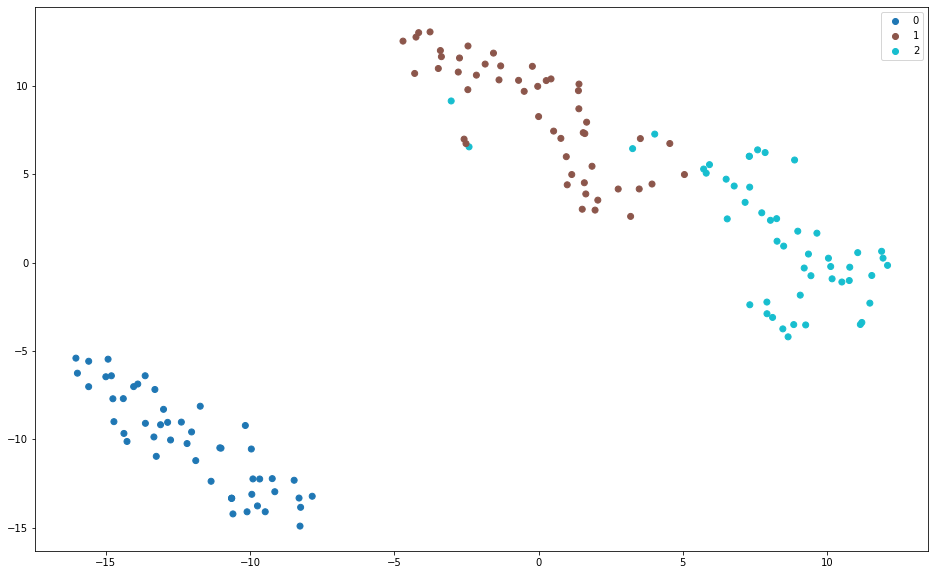

In [ ]:
dataset_labels = [0,1,2]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=iris_labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [ ]:
def run_experiment(K, dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=100).fit(datapoints) 
  cluster_centers = kmeans_initial.cluster_centers_
  cluster_labels = kmeans_initial.labels_
  real_labels = transform_clusters_to_labels(cluster_labels, labels)

  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=cluster_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  kmeans_initial_hungarian_acc = cluster_accuracy(labels, cluster_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(labels, cluster_labels)
  kmeans_initial_ARI = adjusted_rand_score(labels, cluster_labels)

  print("K_means greedy accuracy score (initial space):",accuracy_score(labels, real_labels))
  print("K_means hungarian accuracy score (initial space):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space):",kmeans_initial_NMI)
  print("ARI (initial space):",kmeans_initial_ARI, "\n")

  # using the autoencoder model on our data

  print('Using the autoencoder model on our data: \n')

  kmeans_accuracy_scores = []
  k_means_silhouette_scores = []
  k_means_cluster_error_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  
  for i in range(5):

    print("ROUND NUMBER ",i + 1,":\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, cluster_centers, cluster_labels, batch_size=50, epochs=epochs)
    latent_data = autoencoder.encoder(datapoints, device)

    data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(latent_data)

    dataset_labels = [0,1]

    plt.figure(figsize=(16,10))
    scatterplot = plt.scatter(
        x=data_TSNE[:,0], y=data_TSNE[:,1],
        c=labels,
        cmap="tab10"
    )

    handles, _ = scatterplot.legend_elements(prop='colors')
    plt.legend(handles, dataset_labels)
    
    print("Creating a k-means model on latent data:\n")

    # Maybe we need Standar Scaler

    # std_scaler = StandardScaler()
    # latent_data = std_scaler.fit_transform(latent_data)

    # Clustering on transformed space

    new_kmeans = KMeans(n_clusters=3, n_init=100).fit(latent_data)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, labels)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(labels, kmeans_greedy_labels)

    # These metrics as input they use the output of the clustering algorithm
    kmeans_hungarian_acc = cluster_accuracy(labels, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(labels, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(labels, kmeans_clusters)

    kmeans_accuracy_scores.append(kmeans_hungarian_acc)
    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    k_means_silhouette_score = silhouette_score(latent_data, kmeans_clusters)
    k_means_silhouette_scores.append(k_means_silhouette_score)

    print("K-means with 10 clusters on latent space stats: \n")
    print("K-means on latent space greedy accuracy score:",kmeans_greedy_acc)
    print("K-means on latent space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on latent space:", kmeans_NMI)
    print("ARI score on k-means on latent space:", kmeans_ARI)
    print("K-means cluster error on latent space:", kmeans_cluster_error)
    print("K-means silhouette score on latent space:", k_means_silhouette_score, "\n")

    # do agglomerative clustering on the transformed space

    print("Doing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=3).fit(latent_data)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, labels)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(labels, agglo_greedy_labels)
    agglo_hungarian_acc = cluster_accuracy(labels, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(labels, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(labels, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)

    print("Agglomerative clustering on latent space greedy accuracy score:", agglo_greedy_acc)
    print("Agglomerative clustering on latent space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on latent space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on latent space:", agglo_ARI, "\n")

  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average k-means silhouette score on latent space:", sum(k_means_silhouette_scores) / len(k_means_silhouette_scores), "\n")
  print("Average k-means cluster error on latent space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return [ kmeans_accuracy_scores, kmeans_NMI_scores, kmeans_ARI_scores, agglo_accuracy_scores, agglo_NMI_scores, agglo_ARI_scores, k_means_silhouette_scores]

In [ ]:
results_for_k_5 = run_experiment(5, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 5 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.86
K_means hungarian accuracy score (initial space): 0.86
Normalised mutual info score (initial space): 0.7593367628576805
ARI (initial space): 0.6736713703529151 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.101164
Epoch: 2/50, Loss: 0.084147
Epoch: 3/50, Loss: 0.084352
Epoch: 4/50, Loss: 0.083969
Epoch: 5/50, Loss: 0.083074
Epoch: 6/50, Loss: 0.082280
Epoch: 7/50, Loss: 0.081748
Epoch: 8/50, Loss: 0.081436
Epoch: 9/50, Loss: 0.081148
Epoch: 10/50, Loss: 0.080841
Epoch: 11/50, Loss: 0.080689
Epoch: 12/50, Loss: 0.080433
Epoch: 13/50, Loss: 0.080161
Epoch: 14/50, Loss: 0.079886
Epoch: 15/50, Loss: 0.079639
Epoch: 16/50, Loss: 0.079436
Epoch: 17/50, Loss: 0.079205
Epoch: 18/50, Loss: 0.078976
Epoch: 19/50, Loss: 0.078749
Epoch: 20/50, Loss: 0.078493
Epoch: 21/50, Loss: 0.078275
Epoch: 22

In [ ]:
results_for_k_10 = run_experiment(10, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 10 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9266666666666666
K_means hungarian accuracy score (initial space): 0.9266666666666666
Normalised mutual info score (initial space): 0.791886311123969
ARI (initial space): 0.8016599157804853 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.070341
Epoch: 2/50, Loss: 0.063563
Epoch: 3/50, Loss: 0.063914
Epoch: 4/50, Loss: 0.062259
Epoch: 5/50, Loss: 0.061518
Epoch: 6/50, Loss: 0.061184
Epoch: 7/50, Loss: 0.060818
Epoch: 8/50, Loss: 0.060669
Epoch: 9/50, Loss: 0.060413
Epoch: 10/50, Loss: 0.060149
Epoch: 11/50, Loss: 0.059863
Epoch: 12/50, Loss: 0.059569
Epoch: 13/50, Loss: 0.059321
Epoch: 14/50, Loss: 0.059054
Epoch: 15/50, Loss: 0.058745
Epoch: 16/50, Loss: 0.058362
Epoch: 17/50, Loss: 0.057936
Epoch: 18/50, Loss: 0.057302
Epoch: 19/50, Loss: 0.056782
Epoch: 20/50, Loss: 0.055748
Epoch: 21/

In [ ]:
results_for_k_15 = run_experiment(15, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 15 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.96
K_means hungarian accuracy score (initial space): 0.96
Normalised mutual info score (initial space): 0.8862311759668311
ARI (initial space): 0.8859501978730681 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.091070
Epoch: 2/50, Loss: 0.081543
Epoch: 3/50, Loss: 0.081672
Epoch: 4/50, Loss: 0.080759
Epoch: 5/50, Loss: 0.079811
Epoch: 6/50, Loss: 0.079737
Epoch: 7/50, Loss: 0.079151
Epoch: 8/50, Loss: 0.078400
Epoch: 9/50, Loss: 0.078008
Epoch: 10/50, Loss: 0.077758
Epoch: 11/50, Loss: 0.077434
Epoch: 12/50, Loss: 0.077216
Epoch: 13/50, Loss: 0.077031
Epoch: 14/50, Loss: 0.076719
Epoch: 15/50, Loss: 0.076468
Epoch: 16/50, Loss: 0.076195
Epoch: 17/50, Loss: 0.075815
Epoch: 18/50, Loss: 0.075529
Epoch: 19/50, Loss: 0.075282
Epoch: 20/50, Loss: 0.074867
Epoch: 21/50, Loss: 0.074632
Epoch: 2

In [ ]:
results_for_k_20 = run_experiment(20, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9533333333333334
K_means hungarian accuracy score (initial space): 0.9533333333333334
Normalised mutual info score (initial space): 0.8497805624880206
ARI (initial space): 0.8681109348039796 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.080792
Epoch: 2/50, Loss: 0.072938
Epoch: 3/50, Loss: 0.072793
Epoch: 4/50, Loss: 0.070973
Epoch: 5/50, Loss: 0.070550
Epoch: 6/50, Loss: 0.070366
Epoch: 7/50, Loss: 0.069984
Epoch: 8/50, Loss: 0.069706
Epoch: 9/50, Loss: 0.069264
Epoch: 10/50, Loss: 0.068939
Epoch: 11/50, Loss: 0.068663
Epoch: 12/50, Loss: 0.068304
Epoch: 13/50, Loss: 0.067837
Epoch: 14/50, Loss: 0.067317
Epoch: 15/50, Loss: 0.066737
Epoch: 16/50, Loss: 0.066148
Epoch: 17/50, Loss: 0.066135
Epoch: 18/50, Loss: 0.064699
Epoch: 19/50, Loss: 0.065256
Epoch: 20/50, Loss: 0.063861
Epoch: 21

In [ ]:
results_for_k_25 = run_experiment(25, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 25 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9533333333333334
K_means hungarian accuracy score (initial space): 0.9533333333333334
Normalised mutual info score (initial space): 0.8571871881141627
ARI (initial space): 0.8682571050219008 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.077205
Epoch: 2/50, Loss: 0.068445
Epoch: 3/50, Loss: 0.066961
Epoch: 4/50, Loss: 0.067302
Epoch: 5/50, Loss: 0.066788
Epoch: 6/50, Loss: 0.066133
Epoch: 7/50, Loss: 0.065672
Epoch: 8/50, Loss: 0.065285
Epoch: 9/50, Loss: 0.064964
Epoch: 10/50, Loss: 0.064756
Epoch: 11/50, Loss: 0.064606
Epoch: 12/50, Loss: 0.064406
Epoch: 13/50, Loss: 0.064164
Epoch: 14/50, Loss: 0.063952
Epoch: 15/50, Loss: 0.063747
Epoch: 16/50, Loss: 0.063516
Epoch: 17/50, Loss: 0.063281
Epoch: 18/50, Loss: 0.063049
Epoch: 19/50, Loss: 0.062781
Epoch: 20/50, Loss: 0.062437
Epoch: 21

In [ ]:
results_for_k_30 = run_experiment(30, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.96
K_means hungarian accuracy score (initial space): 0.96
Normalised mutual info score (initial space): 0.8641855068202218
ARI (initial space): 0.8856970310281228 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.072238
Epoch: 2/50, Loss: 0.065952
Epoch: 3/50, Loss: 0.064339
Epoch: 4/50, Loss: 0.064331
Epoch: 5/50, Loss: 0.063929
Epoch: 6/50, Loss: 0.063264
Epoch: 7/50, Loss: 0.062915
Epoch: 8/50, Loss: 0.062698
Epoch: 9/50, Loss: 0.062450
Epoch: 10/50, Loss: 0.062206
Epoch: 11/50, Loss: 0.061932
Epoch: 12/50, Loss: 0.061712
Epoch: 13/50, Loss: 0.061501
Epoch: 14/50, Loss: 0.061295
Epoch: 15/50, Loss: 0.061092
Epoch: 16/50, Loss: 0.060890
Epoch: 17/50, Loss: 0.060694
Epoch: 18/50, Loss: 0.060522
Epoch: 19/50, Loss: 0.060331
Epoch: 20/50, Loss: 0.060122
Epoch: 21/50, Loss: 0.059928
Epoch: 2

In [ ]:
results_for_k_35 = run_experiment(35, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 35 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9666666666666667
K_means hungarian accuracy score (initial space): 0.9666666666666667
Normalised mutual info score (initial space): 0.885062096655338
ARI (initial space): 0.9037675791580496 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.088023
Epoch: 2/50, Loss: 0.075198
Epoch: 3/50, Loss: 0.073905
Epoch: 4/50, Loss: 0.073798
Epoch: 5/50, Loss: 0.072495
Epoch: 6/50, Loss: 0.071468
Epoch: 7/50, Loss: 0.071278
Epoch: 8/50, Loss: 0.071049
Epoch: 9/50, Loss: 0.070653
Epoch: 10/50, Loss: 0.070261
Epoch: 11/50, Loss: 0.069947
Epoch: 12/50, Loss: 0.069602
Epoch: 13/50, Loss: 0.069127
Epoch: 14/50, Loss: 0.068560
Epoch: 15/50, Loss: 0.067953
Epoch: 16/50, Loss: 0.067478
Epoch: 17/50, Loss: 0.066736
Epoch: 18/50, Loss: 0.066086
Epoch: 19/50, Loss: 0.065355
Epoch: 20/50, Loss: 0.064898
Epoch: 21/

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9733333333333334
K_means hungarian accuracy score (initial space): 0.9733333333333334
Normalised mutual info score (initial space): 0.9011219347136157
ARI (initial space): 0.9221767019765943 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.060461
Epoch: 2/50, Loss: 0.051231
Epoch: 3/50, Loss: 0.050466
Epoch: 4/50, Loss: 0.050156
Epoch: 5/50, Loss: 0.049596
Epoch: 6/50, Loss: 0.048865
Epoch: 7/50, Loss: 0.048210
Epoch: 8/50, Loss: 0.047920
Epoch: 9/50, Loss: 0.047436
Epoch: 10/50, Loss: 0.047321
Epoch: 11/50, Loss: 0.046505
Epoch: 12/50, Loss: 0.046376
Epoch: 13/50, Loss: 0.045933
Epoch: 14/50, Loss: 0.045674
Epoch: 15/50, Loss: 0.045595
Epoch: 16/50, Loss: 0.045050
Epoch: 17/50, Loss: 0.044884
Epoch: 18/50, Loss: 0.044671
Epoch: 19/50, Loss: 0.044566
Epoch: 20/50, Loss: 0.044112
Epoch: 21

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.047634
[t-SNE] KL divergence after 400 iterations: 0.334369
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 0.56
K-means on latent space hungarian accuracy score: 0.56
Normalised mutual info score on k-means on latent space: 0.1413802180446602
ARI score on k-means on latent space: 0.14346514640535135
K-means cluster error on latent space: 136.77877807617188
K-means silhouette score on latent space: 0.3650755 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 0.4533333333333333
Agglomerative clustering on latent space hungarian accuracy score: 0.4533333333333333
Normalised mutual info score on agglomerative clustering on latent space: 0.0901530738761498 

ARI score on agglomerative clustering on latent space: 0.050737114730240666 

ROUND NUMBER  2 :

Epoch: 1

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.043423
[t-SNE] KL divergence after 400 iterations: 0.299508
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 0.5266666666666666
K-means on latent space hungarian accuracy score: 0.5266666666666666
Normalised mutual info score on k-means on latent space: 0.1483184164776955
ARI score on k-means on latent space: 0.10794164407370178
K-means cluster error on latent space: 145.44631958007812
K-means silhouette score on latent space: 0.413862 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 0.5333333333333333
Agglomerative clustering on latent space hungarian accuracy score: 0.5333333333333333
Normalised mutual info score on agglomerative clustering on latent space: 0.1277934116868225 

ARI score on agglomerative clustering on latent space: 0.10506359239553542 

R

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,



[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.740818
[t-SNE] KL divergence after 400 iterations: 0.165631
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 0.8466666666666667
K-means on latent space hungarian accuracy score: 0.8466666666666667
Normalised mutual info score on k-means on latent space: 0.6667046012440934
ARI score on k-means on latent space: 0.640438111619406
K-means cluster error on latent space: 108.01686096191406
K-means silhouette score on latent space: 0.50918406 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 0.7866666666666666
Agglomerative clustering on latent space hungarian accuracy score: 0.7866666666666666
Normalised mutual info score on agglomerative clustering on latent space: 0.6519973746213014 

ARI score on agglomerative clustering on latent space: 0.574922408923394 

RO

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.671425
[t-SNE] KL divergence after 400 iterations: 0.283139
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 0.58
K-means on latent space hungarian accuracy score: 0.58
Normalised mutual info score on k-means on latent space: 0.14831017915398542
ARI score on k-means on latent space: 0.14645820210079735
K-means cluster error on latent space: 131.20016479492188
K-means silhouette score on latent space: 0.41013318 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 0.5066666666666667
Agglomerative clustering on latent space hungarian accuracy score: 0.5066666666666667
Normalised mutual info score on agglomerative clustering on latent space: 0.07354858076116248 

ARI score on agglomerative clustering on latent space: 0.07045916062686433 

ROUND NUMBER  5 :

Epoch:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.333813
[t-SNE] KL divergence after 400 iterations: 0.281472
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 0.6466666666666666
K-means on latent space hungarian accuracy score: 0.6466666666666666
Normalised mutual info score on k-means on latent space: 0.41682188971448125
ARI score on k-means on latent space: 0.3871988098634015
K-means cluster error on latent space: 182.12425231933594
K-means silhouette score on latent space: 0.43111226 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 0.64
Agglomerative clustering on latent space hungarian accuracy score: 0.64
Normalised mutual info score on agglomerative clustering on latent space: 0.4173282868601659 

ARI score on agglomerative clustering on latent space: 0.37394060201052587 

Average k-means accuracy sc

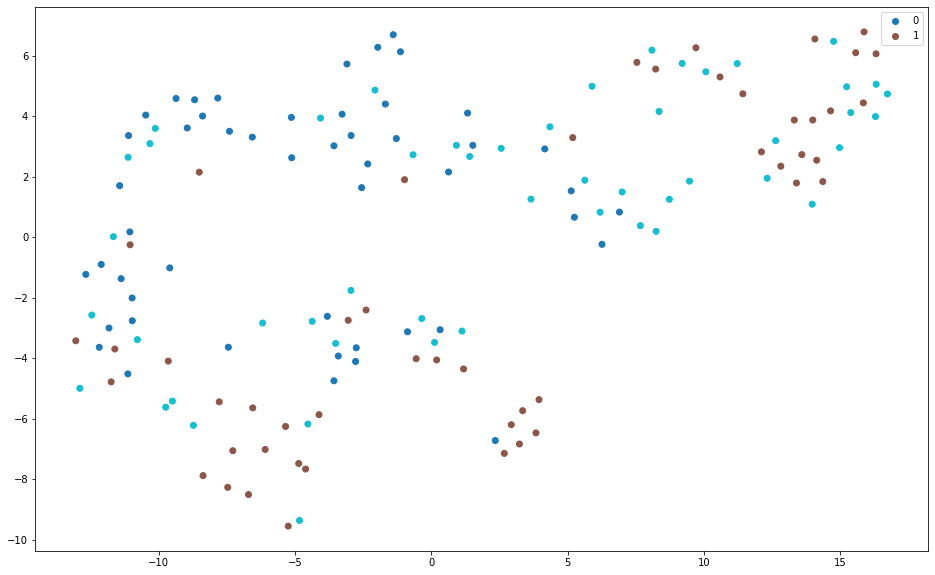

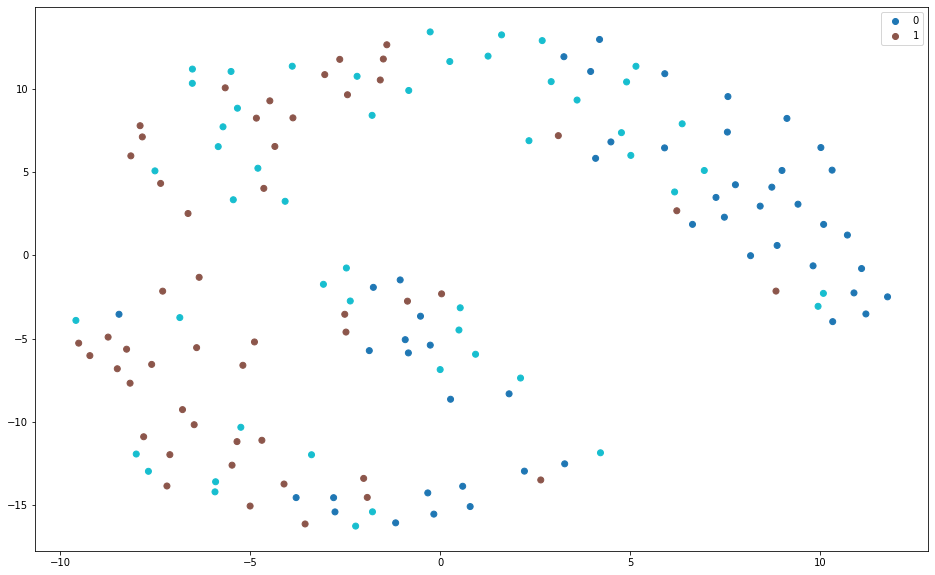

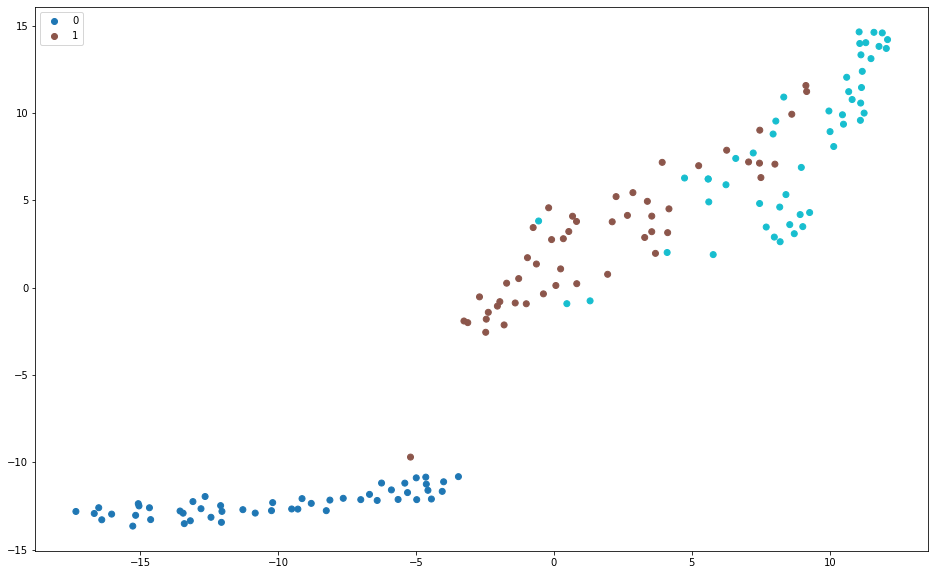

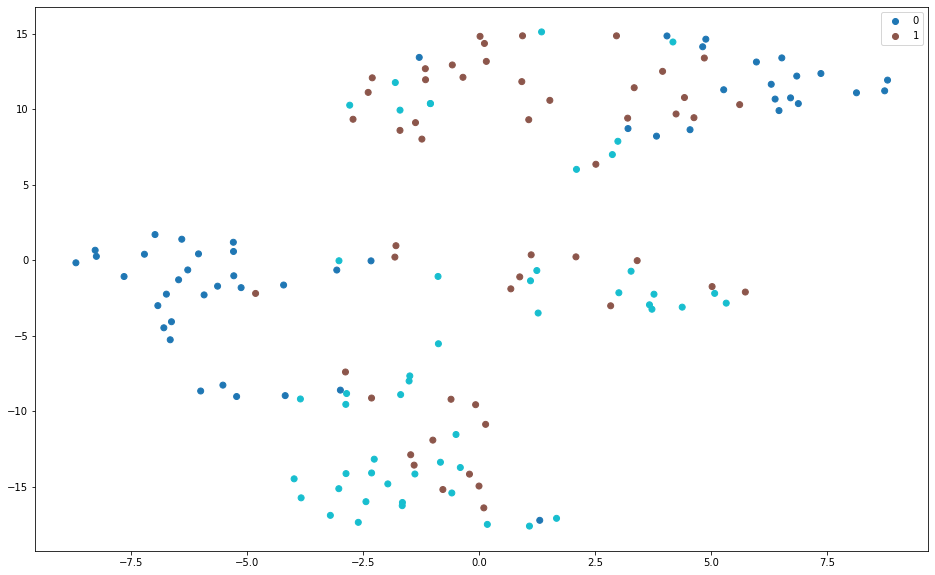

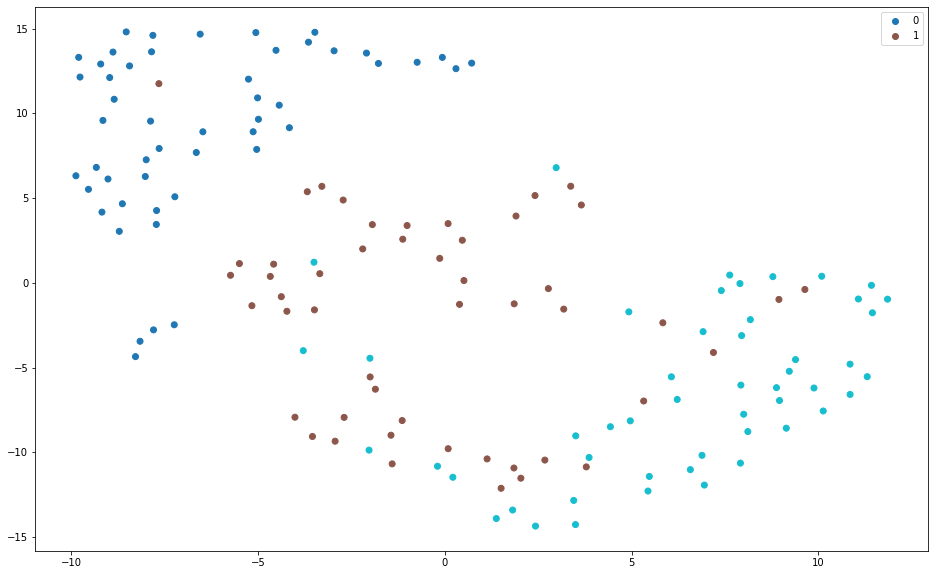

In [ ]:
results_for_k_40 = run_experiment(40, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

In [ ]:
results_for_k_45 = run_experiment(45, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 45 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.98
K_means hungarian accuracy score (initial space): 0.98
Normalised mutual info score (initial space): 0.9192316125079696
ARI (initial space): 0.9410122562924206 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.084721
Epoch: 2/50, Loss: 0.067304
Epoch: 3/50, Loss: 0.066264
Epoch: 4/50, Loss: 0.065665
Epoch: 5/50, Loss: 0.064312
Epoch: 6/50, Loss: 0.063671
Epoch: 7/50, Loss: 0.063369
Epoch: 8/50, Loss: 0.063079
Epoch: 9/50, Loss: 0.062904
Epoch: 10/50, Loss: 0.062750
Epoch: 11/50, Loss: 0.062485
Epoch: 12/50, Loss: 0.062294
Epoch: 13/50, Loss: 0.062184
Epoch: 14/50, Loss: 0.062053
Epoch: 15/50, Loss: 0.061912
Epoch: 16/50, Loss: 0.061795
Epoch: 17/50, Loss: 0.061686
Epoch: 18/50, Loss: 0.061579
Epoch: 19/50, Loss: 0.061477
Epoch: 20/50, Loss: 0.061367
Epoch: 21/50, Loss: 0.061249
Epoch: 2

In [ ]:
results_for_k_50 = run_experiment(50, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9733333333333334
K_means hungarian accuracy score (initial space): 0.9733333333333334
Normalised mutual info score (initial space): 0.8980870992332946
ARI (initial space): 0.9221551020408163 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.106266
Epoch: 2/50, Loss: 0.100193
Epoch: 3/50, Loss: 0.100960
Epoch: 4/50, Loss: 0.100044
Epoch: 5/50, Loss: 0.098830
Epoch: 6/50, Loss: 0.098399
Epoch: 7/50, Loss: 0.098039
Epoch: 8/50, Loss: 0.097688
Epoch: 9/50, Loss: 0.097331
Epoch: 10/50, Loss: 0.096896
Epoch: 11/50, Loss: 0.096488
Epoch: 12/50, Loss: 0.096160
Epoch: 13/50, Loss: 0.095785
Epoch: 14/50, Loss: 0.095401
Epoch: 15/50, Loss: 0.095015
Epoch: 16/50, Loss: 0.094547
Epoch: 17/50, Loss: 0.094102
Epoch: 18/50, Loss: 0.093538
Epoch: 19/50, Loss: 0.092949
Epoch: 20/50, Loss: 0.092336
Epoch: 21

In [ ]:
results_for_k_55 = run_experiment(55, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9866666666666667
K_means hungarian accuracy score (initial space): 0.9866666666666667
Normalised mutual info score (initial space): 0.9487883204351097
ARI (initial space): 0.9602776916338867 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.061321
Epoch: 2/50, Loss: 0.055030
Epoch: 3/50, Loss: 0.054864
Epoch: 4/50, Loss: 0.053818
Epoch: 5/50, Loss: 0.053045
Epoch: 6/50, Loss: 0.052927
Epoch: 7/50, Loss: 0.052373
Epoch: 8/50, Loss: 0.051351
Epoch: 9/50, Loss: 0.050975
Epoch: 10/50, Loss: 0.049852
Epoch: 11/50, Loss: 0.049804
Epoch: 12/50, Loss: 0.049132
Epoch: 13/50, Loss: 0.048821
Epoch: 14/50, Loss: 0.049016
Epoch: 15/50, Loss: 0.052438
Epoch: 16/50, Loss: 0.049284
Epoch: 17/50, Loss: 0.049488
Epoch: 18/50, Loss: 0.049202
Epoch: 19/50, Loss: 0.047909
Epoch: 20/50, Loss: 0.047095
Epoch: 21

In [ ]:
results_for_k_60 = run_experiment(60, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 60 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.98
K_means hungarian accuracy score (initial space): 0.98
Normalised mutual info score (initial space): 0.930550662157643
ARI (initial space): 0.9410449800736683 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.059102
Epoch: 2/50, Loss: 0.046963
Epoch: 3/50, Loss: 0.047323
Epoch: 4/50, Loss: 0.046915
Epoch: 5/50, Loss: 0.046459
Epoch: 6/50, Loss: 0.045954
Epoch: 7/50, Loss: 0.045582
Epoch: 8/50, Loss: 0.045290
Epoch: 9/50, Loss: 0.045013
Epoch: 10/50, Loss: 0.044814
Epoch: 11/50, Loss: 0.044652
Epoch: 12/50, Loss: 0.044464
Epoch: 13/50, Loss: 0.044255
Epoch: 14/50, Loss: 0.044043
Epoch: 15/50, Loss: 0.043803
Epoch: 16/50, Loss: 0.043538
Epoch: 17/50, Loss: 0.043266
Epoch: 18/50, Loss: 0.042961
Epoch: 19/50, Loss: 0.042593
Epoch: 20/50, Loss: 0.042128
Epoch: 21/50, Loss: 0.041547
Epoch: 22

In [ ]:
kmeans_acc = np.zeros((5,12))
kmeans_NMI = np.zeros((5,12))
kmeans_ARI = np.zeros((5,12))
agglo_acc = np.zeros((5,12))
agglo_NMI = np.zeros((5,12))
agglo_ARI = np.zeros((5,12))
kmeans_silhouette = np.zeros((5,12))

for i in range(5):
  
  kmeans_acc[i][0] = results_for_k_5[0][i]
  kmeans_acc[i][1] = results_for_k_10[0][i]
  kmeans_acc[i][2] = results_for_k_15[0][i]
  kmeans_acc[i][3] = results_for_k_20[0][i]
  kmeans_acc[i][4] = results_for_k_25[0][i]
  kmeans_acc[i][5] = results_for_k_30[0][i]
  kmeans_acc[i][6] = results_for_k_35[0][i]
  kmeans_acc[i][7] = results_for_k_40[0][i]
  kmeans_acc[i][8] = results_for_k_45[0][i]
  kmeans_acc[i][9] = results_for_k_50[0][i]
  kmeans_acc[i][10] = results_for_k_55[0][i]
  kmeans_acc[i][11] = results_for_k_60[0][i]

  kmeans_NMI[i][0] = results_for_k_5[1][i]
  kmeans_NMI[i][1] = results_for_k_10[1][i]
  kmeans_NMI[i][2] = results_for_k_15[1][i]
  kmeans_NMI[i][3] = results_for_k_20[1][i]
  kmeans_NMI[i][4] = results_for_k_25[1][i]
  kmeans_NMI[i][5] = results_for_k_30[1][i]
  kmeans_NMI[i][6] = results_for_k_35[1][i]
  kmeans_NMI[i][7] = results_for_k_40[1][i]
  kmeans_NMI[i][8] = results_for_k_45[1][i]
  kmeans_NMI[i][9] = results_for_k_50[1][i]
  kmeans_NMI[i][10] = results_for_k_55[1][i]
  kmeans_NMI[i][11] = results_for_k_60[1][i]

  kmeans_ARI[i][0] = results_for_k_5[2][i]
  kmeans_ARI[i][1] = results_for_k_10[2][i]
  kmeans_ARI[i][2] = results_for_k_15[2][i]
  kmeans_ARI[i][3] = results_for_k_20[2][i]
  kmeans_ARI[i][4] = results_for_k_25[2][i]
  kmeans_ARI[i][5] = results_for_k_30[2][i]
  kmeans_ARI[i][6] = results_for_k_35[2][i]
  kmeans_ARI[i][7] = results_for_k_40[2][i]
  kmeans_ARI[i][8] = results_for_k_45[2][i]
  kmeans_ARI[i][9] = results_for_k_50[2][i]
  kmeans_ARI[i][10] = results_for_k_55[2][i]
  kmeans_ARI[i][11] = results_for_k_60[2][i]

  agglo_acc[i][0] = results_for_k_5[3][i]
  agglo_acc[i][1] = results_for_k_10[3][i]
  agglo_acc[i][2] = results_for_k_15[3][i]
  agglo_acc[i][3] = results_for_k_20[3][i]
  agglo_acc[i][4] = results_for_k_25[3][i]
  agglo_acc[i][5] = results_for_k_30[3][i]
  agglo_acc[i][6] = results_for_k_35[3][i]
  agglo_acc[i][7] = results_for_k_40[3][i]
  agglo_acc[i][8] = results_for_k_45[3][i]
  agglo_acc[i][9] = results_for_k_50[3][i]
  agglo_acc[i][10] = results_for_k_55[3][i]
  agglo_acc[i][11] = results_for_k_60[3][i]

  agglo_NMI[i][0] = results_for_k_5[4][i]
  agglo_NMI[i][1] = results_for_k_10[4][i]
  agglo_NMI[i][2] = results_for_k_15[4][i]
  agglo_NMI[i][3] = results_for_k_20[4][i]
  agglo_NMI[i][4] = results_for_k_25[4][i]
  agglo_NMI[i][5] = results_for_k_30[4][i]
  agglo_NMI[i][6] = results_for_k_35[4][i]
  agglo_NMI[i][7] = results_for_k_40[4][i]
  agglo_NMI[i][8] = results_for_k_45[4][i]
  agglo_NMI[i][9] = results_for_k_50[4][i]
  agglo_NMI[i][10] = results_for_k_55[4][i]
  agglo_NMI[i][11] = results_for_k_60[4][i]

  agglo_ARI[i][0] = results_for_k_5[5][i]
  agglo_ARI[i][1] = results_for_k_10[5][i]
  agglo_ARI[i][2] = results_for_k_15[5][i]
  agglo_ARI[i][3] = results_for_k_20[5][i]
  agglo_ARI[i][4] = results_for_k_25[5][i]
  agglo_ARI[i][5] = results_for_k_30[5][i]
  agglo_ARI[i][6] = results_for_k_35[5][i]
  agglo_ARI[i][7] = results_for_k_40[5][i]
  agglo_ARI[i][8] = results_for_k_45[5][i]
  agglo_ARI[i][9] = results_for_k_50[5][i]
  agglo_ARI[i][10] = results_for_k_55[5][i]
  agglo_ARI[i][11] = results_for_k_60[5][i]

  kmeans_silhouette[i][0] = results_for_k_5[6][i]
  kmeans_silhouette[i][1] = results_for_k_10[6][i]
  kmeans_silhouette[i][2] = results_for_k_15[6][i]
  kmeans_silhouette[i][3] = results_for_k_20[6][i]
  kmeans_silhouette[i][4] = results_for_k_25[6][i]
  kmeans_silhouette[i][5] = results_for_k_30[6][i]
  kmeans_silhouette[i][6] = results_for_k_35[6][i]
  kmeans_silhouette[i][7] = results_for_k_40[6][i]
  kmeans_silhouette[i][8] = results_for_k_45[6][i]
  kmeans_silhouette[i][9] = results_for_k_50[6][i]
  kmeans_silhouette[i][10] = results_for_k_55[6][i]
  kmeans_silhouette[i][11] = results_for_k_60[6][i]


Text(0.5, 0, 'K')

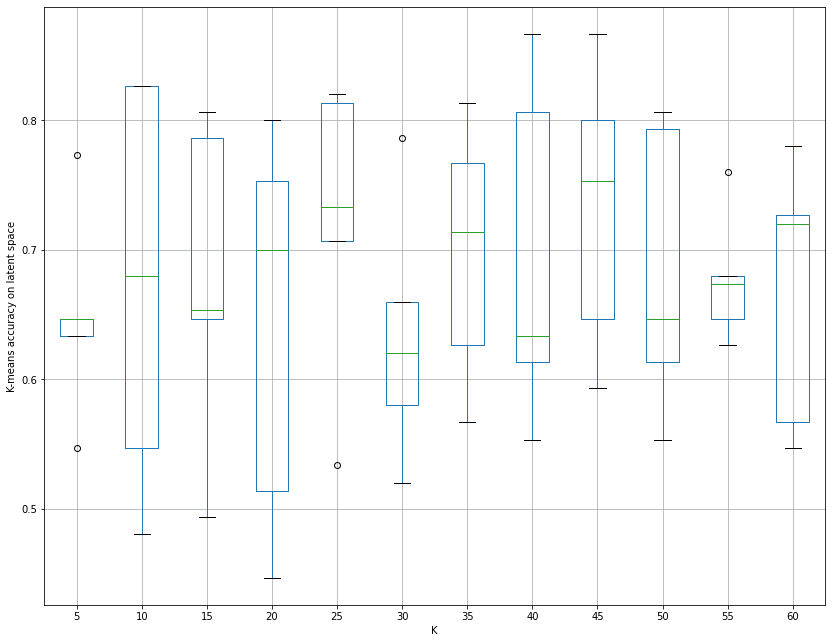

In [ ]:
columns = ['5', '10','15', '20', '25', '30', '35', '40', '45', '50', '55', '60']

df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

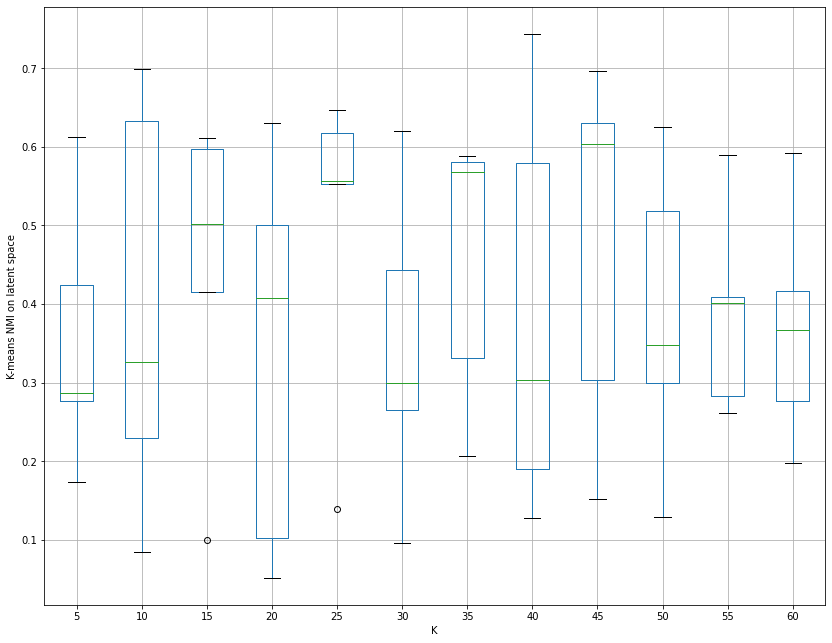

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

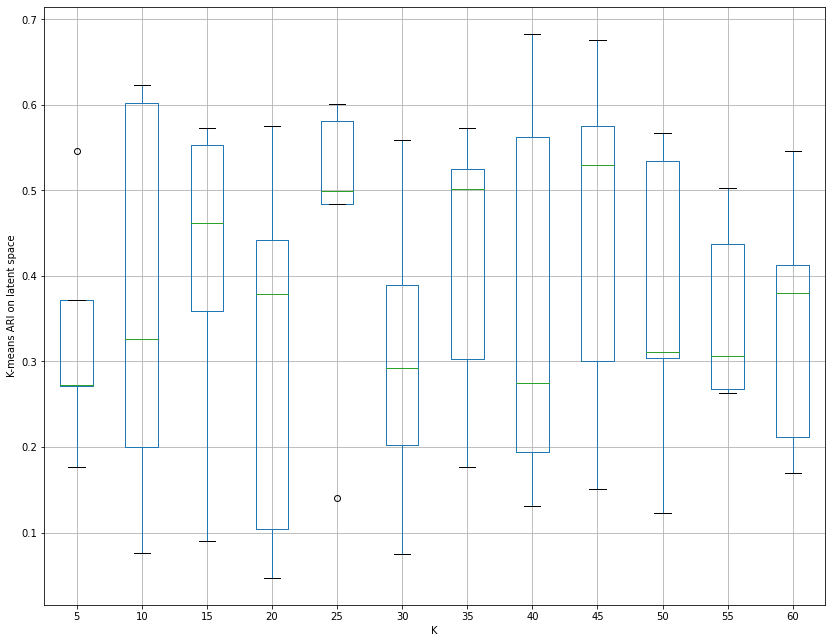

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

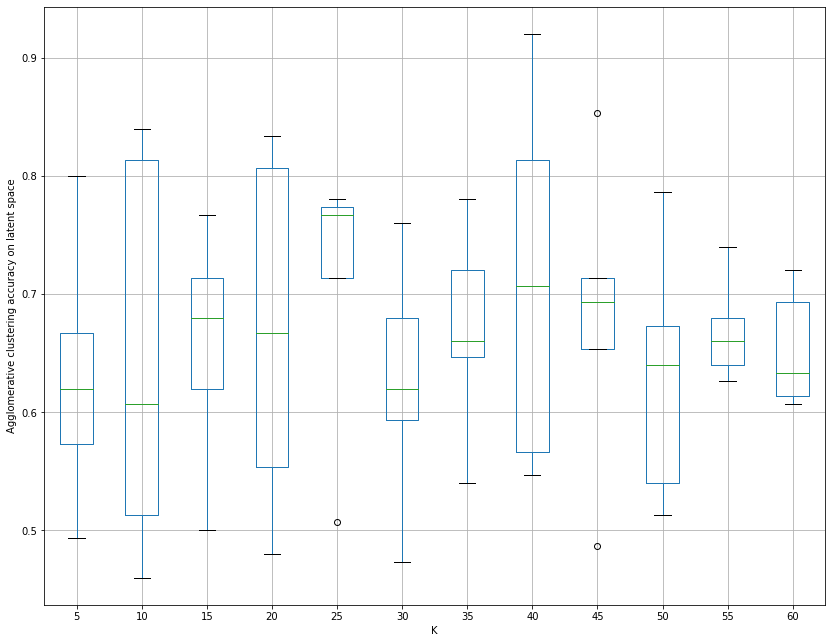

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

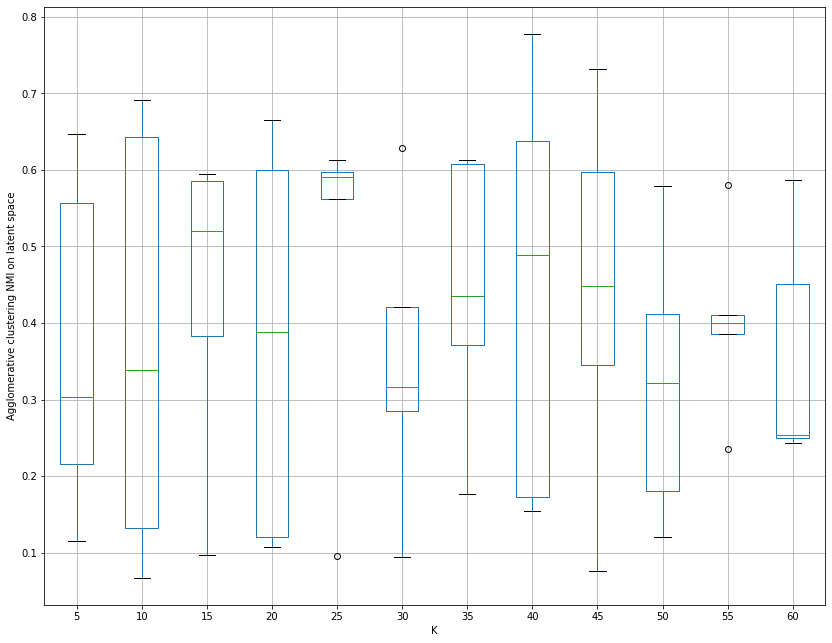

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

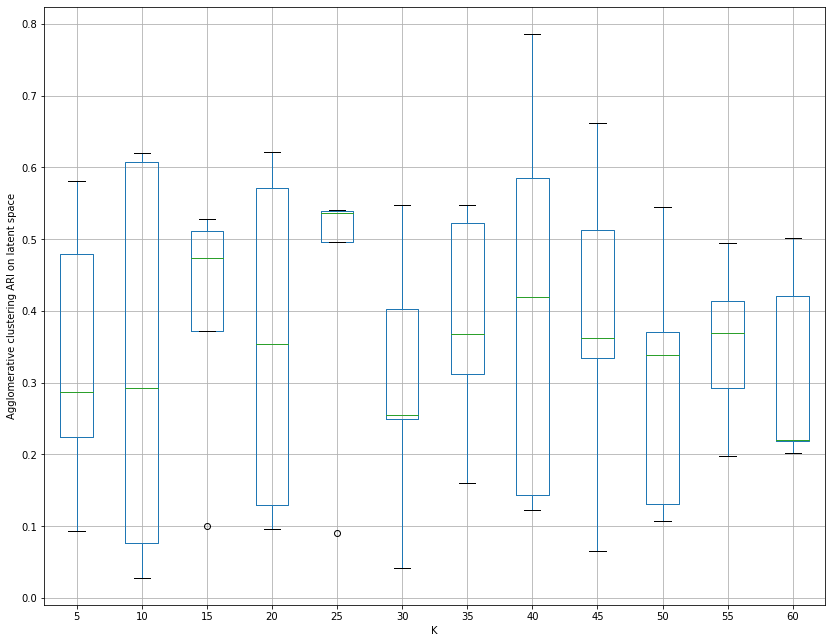

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

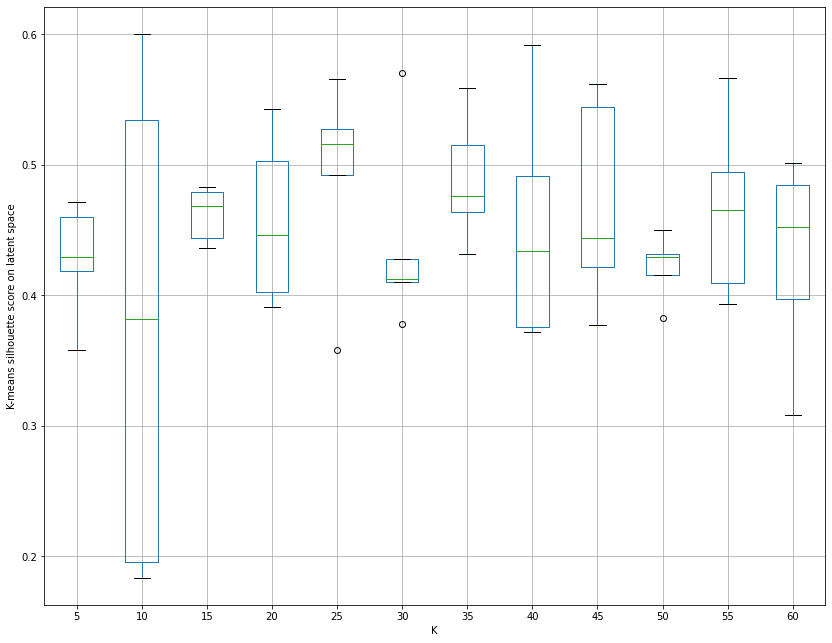

In [ ]:
df = pd.DataFrame(kmeans_silhouette,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means silhouette score on latent space')
boxplot.set_xlabel('K')

# Silhoutte factor

In [ ]:
def get_all_representations(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers):

  representation_K_tuples = []

  for K in list_of_cluster_numbers:
    print("Creating representation for K =", K, ":\n")
    print("Running k-means...\n")
    kmeans = KMeans(n_clusters=K, n_init=100).fit(datapoints)
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_

    # using the autoencoder model on our data

    print("Training autoencoder...\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, cluster_centers, cluster_labels, epochs=epochs)
    print("\n")
    latent_data = autoencoder.encoder(datapoints, device)
    r = latent_data

    representation_K_tuples.append((r,K))

  return representation_K_tuples


In [ ]:
def calculate_silhouette_for_each_representation(representation_tuples, list_of_cluster_numbers):
  representations = [pair[0] for pair in representation_tuples]
  rep_silhouette_list = [[] for i in range(len(representations))]

  for index, rep in enumerate(representations):
    print("Starting process for representation number", index + 1,":\n")
    for K in list_of_cluster_numbers:
      print("Running kmeans for K =", K,"...")
      kmeans = KMeans(n_clusters=K, n_init=100).fit(rep)
      k_means_silhouette_score = silhouette_score(rep, kmeans.labels_)
      rep_silhouette_list[index].append(k_means_silhouette_score)
    print("\n")

  return rep_silhouette_list

In [ ]:
def get_max_silhouette_for_each_representation(rep_silhouette_lst):
  max_silhouette_tuples = [] # keep tuples in the form of (index, max_silhouette)

  for index, silhouette_lst in enumerate(rep_silhouette_lst):
    max = silhouette_lst[0]

    for i in range(1,len(silhouette_lst)):
        if silhouette_lst[i] > max:
            max = silhouette_lst[i]

    max_silhouette_tuples.append((index, max))

  return max_silhouette_tuples

In [ ]:
def calculate_representation_kmeans_acc(representation_tuples, Y):
  representations = [pair[0] for pair in representation_tuples]
  accuracies = []

  for index, rep in enumerate(representations):
    kmeans = KMeans(n_clusters=3, n_init=100).fit(rep)
    kmeans_clusters = kmeans.labels_
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, Y)
    acc = accuracy_score(Y, kmeans_greedy_labels)
    accuracies.append((index,acc))

  return accuracies

In [ ]:
def calculate_normalised_silhouette(max_silhouette_tuples, representation_tuples):
  normalised_silhouette_tuples = []
  representations = [pair[0] for pair in representation_tuples]

  for rep_index, rep in enumerate(representations):
    kmeans = KMeans(n_clusters=3, n_init=100).fit(rep)
    k_means_silhouette_score = silhouette_score(rep, kmeans.labels_)
    normalised_silhouette = (k_means_silhouette_score) / (max_silhouette_tuples[rep_index][1])
    normalised_silhouette_tuples.append((rep_index, normalised_silhouette))


  return normalised_silhouette_tuples

In [ ]:
def silhouette_factor(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers):
  representation_tuples = get_all_representations(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers)
  representation_silhouette_list = calculate_silhouette_for_each_representation(representation_tuples, list_of_cluster_numbers)
  max_silhouette_list = get_max_silhouette_for_each_representation(representation_silhouette_list)
  normalised_silhouette_scores = calculate_normalised_silhouette(max_silhouette_list,representation_tuples)
  k_means_accuracies = calculate_representation_kmeans_acc(representation_tuples, labels)
  print(normalised_silhouette_scores)
  print(k_means_accuracies)

  return normalised_silhouette_scores, k_means_accuracies

In [ ]:
normalised_silhouette_scores, k_means_accuracies = silhouette_factor(iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3, list_of_cluster_numbers=[5,10,15,20,25,30,35,40,45,50,55,60])

Creating representation for K = 5 :

Running k-means...

Training autoencoder...

Epoch: 1/50, Loss: 0.070140
Epoch: 2/50, Loss: 0.064437
Epoch: 3/50, Loss: 0.064009
Epoch: 4/50, Loss: 0.062957
Epoch: 5/50, Loss: 0.062188
Epoch: 6/50, Loss: 0.061660
Epoch: 7/50, Loss: 0.060907
Epoch: 8/50, Loss: 0.060408
Epoch: 9/50, Loss: 0.059927
Epoch: 10/50, Loss: 0.059591
Epoch: 11/50, Loss: 0.059232
Epoch: 12/50, Loss: 0.058860
Epoch: 13/50, Loss: 0.058432
Epoch: 14/50, Loss: 0.058158
Epoch: 15/50, Loss: 0.057721
Epoch: 16/50, Loss: 0.057320
Epoch: 17/50, Loss: 0.056833
Epoch: 18/50, Loss: 0.056326
Epoch: 19/50, Loss: 0.055847
Epoch: 20/50, Loss: 0.055015
Epoch: 21/50, Loss: 0.055058
Epoch: 22/50, Loss: 0.058623
Epoch: 23/50, Loss: 0.057591
Epoch: 24/50, Loss: 0.055265
Epoch: 25/50, Loss: 0.055111
Epoch: 26/50, Loss: 0.054558
Epoch: 27/50, Loss: 0.053853
Epoch: 28/50, Loss: 0.052940
Epoch: 29/50, Loss: 0.051791
Epoch: 30/50, Loss: 0.051392
Epoch: 31/50, Loss: 0.050826
Epoch: 32/50, Loss: 0.050018

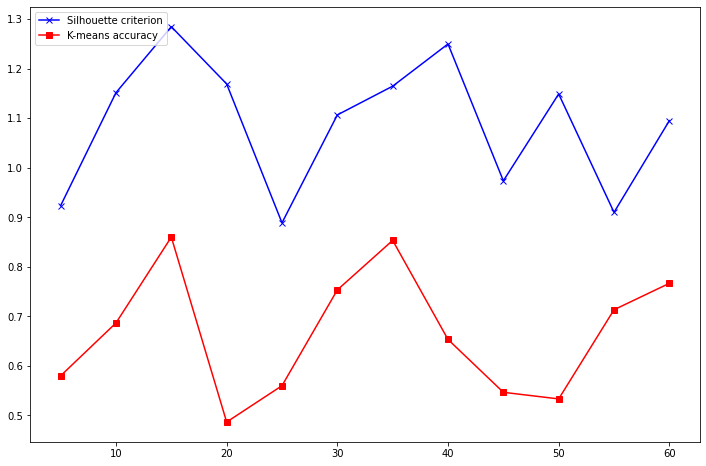

In [ ]:
list_of_cluster_numbers= [5,10,15,20,25,30,35,40,45,50,55,60]

normalised_silhouette_scores = [t[1] for t in normalised_silhouette_scores]
k_means_accuracies = [t[1] for t in k_means_accuracies]

plt.figure(figsize=(12, 8))
plt.plot(list_of_cluster_numbers, normalised_silhouette_scores, c='b', marker='x', label='Silhouette criterion')
plt.plot(list_of_cluster_numbers, k_means_accuracies, c='r', marker='s', label='K-means accuracy')
plt.legend(loc='upper left')
plt.show()